# Movie Lens Dataset


__Team Members:__
- Giorgi Kituashvili - gk2215
- Ritin Malhotra - rm5486
- Soumen Mohanty - sm8966
- Zaeem Shahzad - ms12297


## Milestone 1

### 1. Problem Statement and Hypothesis

### Problem Statement

In the movie industry, understanding audience preferences can be crucial for targeted marketing and content creation. With the rise of data-driven decision-making, leveraging user demographics, like occupation, can provide a deeper understanding of movie preferences.

**Question**: Does the occupation of movie raters correlate with their preferences for certain movie genres?

---

### Hypothesis

#### Null Hypothesis (H_0):
The occupation of movie raters does not have any correlation with the ratings they give to different movie genres. In other words, the distribution of ratings across genres is the same for all occupations.

#### Alternative Hypothesis (H_a):
The occupation of movie raters correlates with the ratings they give to different movie genres. This would imply that certain occupations tend to rate some genres higher or lower than others.

---

### Intuition & Explanation

Occupation can be seen as a reflection of an individual's interests, educational background, and daily activities. For instance, someone in a creative field might have a preference for dramas or art films, while someone in a technical field might lean towards sci-fi or action movies. If our data shows significant differences in genre ratings across occupations, businesses could target their advertising campaigns more effectively, and filmmakers could understand their audience better.

However, it's also possible that movie preferences are more universal and less influenced by one's job. This is the essence of our null hypothesis: that movie genre preferences are independent of occupation.

By testing this hypothesis, we aim to provide insights that could be valuable for movie producers, streaming platforms, and marketing teams.

In our latest update, we transitioned from the 100k MovieLens database to the 1M MovieLens database. This shift required some modifications to our previous notebook. We adapted the applicable sections of the code to align with the new database. Certain code cells that were no longer relevant were removed. However, we retained key elements from the previous submission, like the Feature Transformation section, but have commented these out as they are not currently applicable.

### 2. Studying the Dataset

In [ ]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


#### 2.1. Initial Exploration



Using the README file, we can assign the columns names to the appropriate files. We are then inspecting each dataframe to begin our analysis.

In [ ]:
movies = pd.read_csv('Datasets/movies.dat', sep='::', names=['MovieID', 'Title', 'Genres'], engine='python', encoding='latin-1')

# Break up each genre (separator is '|') into its own row
movies = movies.set_index(['MovieID', 'Title']).Genres.str.split('|', expand=True).stack().reset_index(['MovieID', 'Title'])

movie_cols = ['MovieID', 'Title', 'Genre']
movies.columns = movie_cols

# Create new column for release year (extract from title)
movies['Year'] = movies['Title'].str.extract('.*\((.*)\).*', expand=True)
movies['Title'] = movies['Title'].str.replace(r"\(.*\)","", regex=True)

movies.head()

In [ ]:
ratings = pd.read_csv('Datasets/ratings.dat', sep='::', names=['UserID', 'MovieID', 'Rating', 'Timestamp'], engine='python', encoding='latin-1')

# Convert 'Timestamp' from Unix timestamp to datetime
ratings['Rating Date'] = pd.to_datetime(ratings['Timestamp'], unit='s')

# Convert datetime to date in 'YYYY-MM-DD' format
ratings['Rating Date'] = ratings['Rating Date'].dt.date

ratings

In [ ]:
users = pd.read_csv('Datasets/users.dat', sep='::', names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], engine='python', encoding='latin-1')

# Map Occupation to Occupation Name in 'occupations.csv'
occupations = pd.read_csv('Datasets/occupations.csv', sep=',', names=['Occupation', 'Occupation Name'], engine='python', encoding='latin-1')

# Merge users on occupations
users = users.merge(occupations, on='Occupation', how='left')

# Drop Occupation column
users = users.drop('Occupation', axis=1)

# Rename Occupation Name to Occupation
users = users.rename(columns={'Occupation Name': 'Occupation'})

# Function to categorize age
def categorize_age(age):
    if age < 18:
        return "Under 18"
    elif age < 25:
        return "18-24"
    elif age < 35:
        return "25-34"
    elif age < 45:
        return "35-44"
    elif age < 50:
        return "45-49"
    elif age < 56:
        return "50-55"
    else:
        return "56+"

# Applying the function to create a new column
users['Age_Categories'] = users['Age'].apply(categorize_age)

users

In [ ]:
# Make all column names lowercase in ratings, users, and movies
ratings.columns = ratings.columns.str.lower()
users.columns = users.columns.str.lower()
movies.columns = movies.columns.str.lower()

## 2.2. Identifying Relevant Variables

### Movies Dataset
The `movies_df` contains information about movies, such as the title, release date, and various genre flags (indicating the genres a movie belongs to). The genres are particularly relevant because they represent the categories for which we want to analyze ratings. We'll also use the `movie id` for merging datasets later.

**Key Variables**:
- `movie id`: Will be used to match ratings with movies.
- Genre Flags (e.g., `Action`, `Adventure`, `Animation`, etc.): To categorize movies and analyze ratings based on genre.

### Ratings Dataset
The `ratings_df` provides ratings given by users to movies. The rating and the association between user and movie are crucial.

**Key Variables**:
- `user id`: To identify which user gave a particular rating.
- `movie id`: To match the rating with a specific movie.
- `rating`: The actual rating value, which is central to our analysis.

### Users Dataset
The `users_df` contains demographic information about users. Since our hypothesis revolves around the occupation of users and their ratings, occupation is of paramount importance. Additionally, other demographics might provide supplemental insights.

**Key Variables**:
- `user id`: To match the user's demographic information with their ratings.
- `occupation`: Central to our hypothesis. We'll analyze ratings based on this.
- `age`, `gender`: Additional demographics that might be used for supplemental analysis.

_Given our hypothesis, the occupation of users and the genres of movies are the two most significant variables. We believe that occupation, a reflection of a person's interests and daily activities, might influence their movie preferences. For instance, someone in a technical field might be inclined towards sci-fi movies, while a healthcare worker might prefer dramas. By correlating occupation with genre-based ratings, we can test this belief._

_However, it's essential to understand that correlation does not imply causation. Even if we find a significant correlation between occupation and genre preference, other lurking variables (like age or gender) might also play a role._

## 3. Data Cleaning


### 3.1. Identifying Outliers


For our current datasets, the rating and age columns are the primary numerical features. However, since rating is categorical in nature (with values ranging from 1 to 5), it doesn't typically have "outliers". The age column, on the other hand, can be inspected for any unusual values that fall outside the expected range for human ages.

In [ ]:
# Boxplot for ratings to identify outliers
plt.figure(figsize=(8, 6))
sns.boxplot(x='rating', data=ratings)
plt.title('Boxplot of Movie Ratings')
plt.show()


The boxplot shows us that ratings dataframe does not contain any outliers, as there are no values outside the 1-5 range. The ratings are all between 1 and 5, as expected. Yet, we can make an observation that not many users have rated movies below 2.

In [ ]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Plotting the distribution of age categories
plt.figure(figsize=(10, 6))
sns.countplot(x='age_categories', data=users, order=['Under 18', '18-24', '25-34', '35-44', '45-49', '50-55', '56+'])
plt.title('Distribution of Age Categories')
plt.xlabel('Age Categories')
plt.ylabel('Count')
plt.show()

We don't see any outliers in the age column either. All the ages are within the expected human ages. However, we can see that the majority of users are between 20 and 40 years old. This is an important observation because it might skew our analysis towards the preferences of younger users.

### 3.2 Removing Unnecessary Columns

From our movies dataframe, some columns like IMDb URLs, release date and video release date might not be relevant for our analysis.

Dropping timestamp column from ratings dataframe.

In [ ]:
# Dropping 'timestamp' from the ratings dataset
ratings.drop(columns=['timestamp'], inplace=True)

### 3.3. Handling Missing Values


Different ways to handle missing values:
- Deletion: If the number of missing values in a row or column is substantial, sometimes it's easier to remove that row or column.
- Imputation: For columns with a few missing values, we can replace missing values with the median, mean, or mode of that column. The method of imputation would depend on the nature of the data.

In [ ]:
# Check for missing data
missing_data = {
    "Users": users.isnull().sum(),
    "Ratings": ratings.isnull().sum(),
    "Movies": movies.isnull().sum()
}

print(missing_data)

Here, we can see that none of the colums have any missing values. We can proceed without dropping any rows or columns or imputing any values.

### 3.4. Checking for Duplicates

Duplicate rows can skew the analysis, leading to incorrect conclusions. Thus, identifying and removing them is essential.

In [ ]:
# Check for duplicates in each dataset
duplicates_data = {
    "Users": users.duplicated().sum(),
    "Ratings": ratings.duplicated().sum(),
    "Movies": movies.duplicated().sum()
}

duplicates_data

### 3.5 Feature Transformation

#### Note (2023-11-14): Since we now use the 1M MovieLens dataset which is structured differently, we do not need to perform this feature transformation here. We have just retained the code for reference.

Our aim is to simplify the structure of our movie dataset, specifically the representation of movie genres. In its current form, each genre is represented as a separate column with binary values indicating whether a movie belongs to that genre. This wide-format structure, while informative, can be cumbersome for analysis, especially when we want to correlate ratings with genres and occupations.

The melt() Function
To achieve our objective, we'll use the melt() function from pandas. This function is designed to transform or reshape data from a wide format to a long format.

In a wide format, data is spread across multiple columns, and in a long format, data is stacked into fewer columns, making the dataset longer.

In [ ]:
# # Melt the dataframe to long format with movie id, movie title, and genre
# movies_long = movies_df.melt(id_vars=['movie id', 'movie title'],
#                              value_vars=['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary',
#                                          'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
#                                          'Thriller', 'War', 'Western'],
#                              var_name='genre',
#                              value_name='value')

# # Filtering out rows where the genre value is 1 (i.e., the movie belongs to that genre)
# movies_long_filtered = movies_long[movies_long['value'] == 1].copy()

# # Drop the 'value' column as we don't need it anymore
# movies_long_filtered.drop(columns=['value'], inplace=True)

# movies_long_filtered.head()


After our transformation, it's essential to note that the dataset now contains duplicate movie entries. This is because movies that belong to multiple genres will have a separate row for each genre they are associated with. For example, a movie that belongs to both "Action" and "Adventure" genres will have two rows in the dataset - one for each genre.

While in many scenarios, duplicates are seen as data inconsistencies, in our case, they are intentional and beneficial. These duplicates are vital for our analysis since they allow us to investigate the relationship between occupations and individual movie genres more effectively. Without this structure, our analysis would be limited, and we wouldn't be able to derive meaningful insights about genre preferences across different occupations.

Thus, as we progress, it's crucial to remember that while the movie titles might repeat, each row represents a unique combination of a movie and its genre, which is essential for our hypothesis testing.

### 3.7. Data Type Conversion

Ensuring that all relevant variables are of the correct data type is crucial for our analysis. Incorrect data types can lead to errors during computations or give misleading results.

First, let's examine the data types of the columns in our datasets.

In [ ]:
# Check data types for each dataset
data_types_movies = movies.dtypes
data_types_ratings = ratings.dtypes
data_types_users = users.dtypes

data_types_movies, data_types_ratings, data_types_users

1. **`movie title`** and **`genre`** in the `movies_long_filtered` dataset are of type `object`. Given that these are textual or categorical variables, it's a good idea to convert them to `category` type to reduce memory usage and speed up operations.
  
2. **`gender`** and **`occupation`** in the `users_df` dataset are also of type `object`. They should be converted to `category` type for the same reasons mentioned above.

3. The `ratings_df` dataset seems fine with `int64` type for its columns.


In [ ]:
# Convert 'movie title' and 'genre' in movies_long_filtered dataset to categorical type
movies['title'] = movies['title'].astype('category')
movies['genre'] = movies['genre'].astype('category')

# Convert 'gender' and 'occupation' in users_df dataset to categorical type
users['gender'] = users['gender'].astype('category')
users['occupation'] = users['occupation'].astype('category')


After these conversions, our datasets' columns should now have the optimal data types for our analysis. These conversions help in reducing memory usage and provide faster operations, especially for operations involving categorical variables.

### 3.8 Merging Datasets

Given our hypothesis, we are interested in studying the relationship between `occupation`, `genre`, and `rating`. The data related to these variables is spread across our three datasets:

- `users_df` contains the `occupation` of each user.
- `ratings_df` contains the `rating` given by a user to a movie.
- `movies_long_filtered` contains the `genre` of each movie.

To effectively analyze the relationship between these variables, it's essential to have them in a single dataframe. Merging the dataframes achieves this and facilitates easier and more efficient analyses.

In [ ]:
# Merge ratings and users on UserID
merged_df = pd.merge(ratings, users, on='userid')

# Merging the above result with movies_long_filtered on 'movie id'
merged_df = pd.merge(merged_df, movies, on='movieid')

merged_df.head()

While the comprehensive merged dataframe is valuable, for our specific hypothesis, we only need the occupation, genre, and rating columns. Filtering out unnecessary columns will make our analyses more efficient and focused.

In [ ]:
# Selecting only 'occupation', 'genre', and 'rating' columns
filtered_df = merged_df[['occupation', 'genre', 'rating']]

filtered_df.head()

In [ ]:
# create a folder called 'cleaned_data' to store the data so it can be used in the next milestone
merged_df.to_csv('cleaned_data/merged_df.csv', index=False)


## 4. Basic Data Exploration
### 4.1. Distribution of Ratings
Understanding the overall distribution of ratings can give us an idea of how users generally perceive movies.

In [ ]:
import matplotlib.pyplot as plt

plt.bar(filtered_df['rating'].value_counts().index, filtered_df['rating'].value_counts().values)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


### 4.2. Top Rated Genres
Which genres have the highest average ratings? This can give insights into the most liked genres overall.

In [ ]:
genre_rating = filtered_df.groupby('genre')['rating'].mean().sort_values(ascending=False)
genre_rating.plot(kind='bar', figsize=(14,7))
plt.title('Average Rating per Genre')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.show()


### 4.3. Number of Ratings by Occupation
Understanding the number of ratings by occupation can give us insights into which occupations are most active in rating movies.

In [ ]:
plt.barh(filtered_df['occupation'].value_counts().index, filtered_df['occupation'].value_counts().values)
plt.title('Number of Ratings by Occupation')
plt.xlabel('Count')
plt.ylabel('Occupation')
plt.show()

### 4.4. Average Rating by Occupation
Which occupations give the highest and lowest average ratings?

In [ ]:
occupation_rating = filtered_df.groupby('occupation')['rating'].mean().sort_values(ascending=False)
occupation_rating.plot(kind='bar', figsize=(14,7))
plt.title('Average Rating by Occupation')
plt.xlabel('Occupation')
plt.ylabel('Average Rating')
plt.show()


### 4.5. Most Popular Genres by Occupation
For each occupation, which genre has the highest average rating?

In [ ]:
occupation_genre_rating = filtered_df.groupby(['occupation', 'genre'])['rating'].mean().unstack()
most_popular_genres = occupation_genre_rating.idxmax(axis=1)
print(most_popular_genres)

## Milestone 2
---


In [ ]:
# load dataset from cleaned_data/ folder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# load dataset from cleaned_data/ folder
data = pd.read_csv('cleaned_data/merged_df.csv')

print(data.shape)

data.head()


## (i) Identifying Features in the Movie Ratings Dataset

#### Outcome Variable
- **Rating**: The primary outcome variable in our dataset is the `rating` given to movies. This represents the users' preferences and satisfaction with the movies they watch.

#### Relevant Variables Affecting the Outcome
##### User Demographics
- **Gender (`gender`)**: Gender might influence movie preferences and ratings differently.
- **Age (`age`)**: Different age groups may have distinct tastes and preferences in movies.
- **Occupation (`occupation`)**: Users' professions might reflect in their movie preferences.
- **Age Categories (`age_categories`)**: Provides a broader categorization of age for more general analysis.

#### Movie Characteristics
- **Genre (`genre`)**: The genre of a movie is a significant factor in how it is perceived and rated by users.
- **Year (`year`)**: The release year of a movie could impact its ratings, reflecting changing tastes or a nostalgia factor for older films.

#### Inferred Variables
##### Potential Derived Variables
- **Time-Based Features**: From `rating date`, we can derive features like the month or day of the week to identify temporal trends in movie ratings.
- **Movie Popularity/User Activity**: The number of ratings a movie receives or the number of ratings given by each user could indicate popularity or engagement levels, potentially correlating with their rating behavior.

#### Justification for Feature Selection
- **Demographics**: Standard in preference studies, as different demographic groups often exhibit varied movie preferences.
- **Movie Characteristics**: Key in understanding a movie's appeal and reception among different audiences.
- **Derived Features**: Offer insights into contextual factors and trends that might influence movie ratings.

## Explore the Dataset

In [ ]:
# describe the dataset and don't show scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# describe only rating, age, year
data[['rating', 'age', 'year']].describe()



,rating,age,year
count,2101815.000,2101815.000,2101815.000
mean,3.583,29.607,1986.716
std,1.117,11.727,14.084
min,1.000,1.000,1919.000
25%,3.000,25.000,1982.000
50%,4.000,25.000,1992.000
75%,4.000,35.000,1997.000
max,5.000,56.000,2000.000


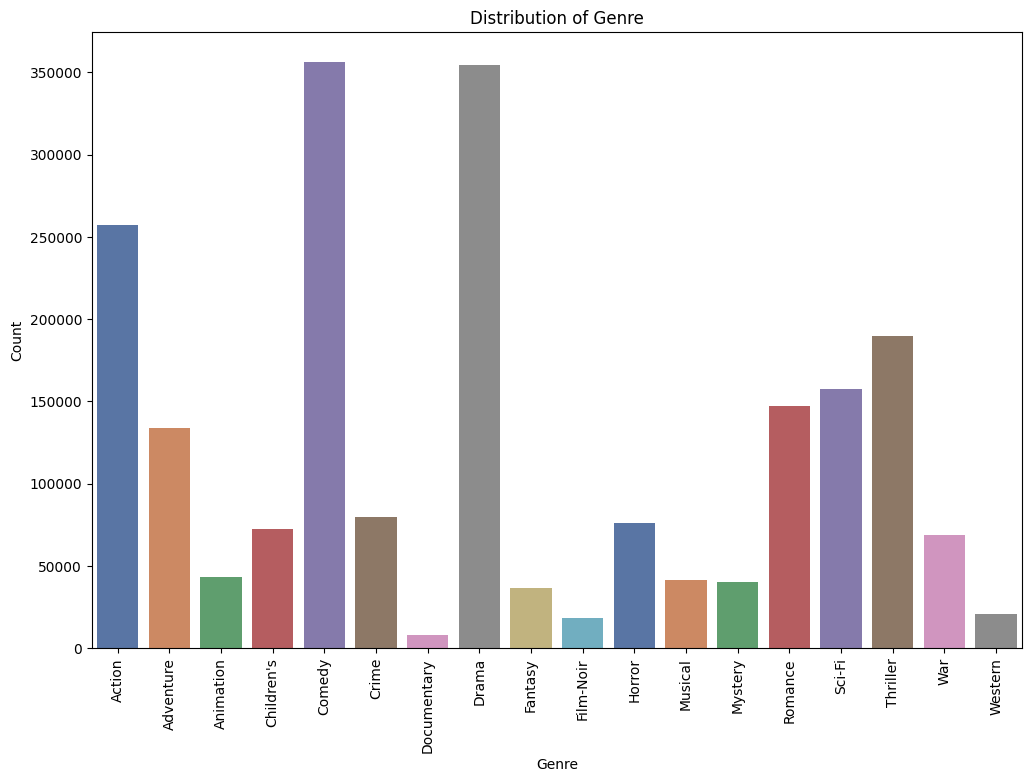

In [ ]:
# create a bar chart for the distribution of genre
# count the number of ratings for each genre value
genre_counts = data['genre'].value_counts()

# sort the genre values
genre_counts = genre_counts.sort_index()

# create a bar chart
plt.figure(figsize=(12, 8))

# set the title
plt.title('Distribution of Genre')

# set the x-axis label
plt.xlabel('Genre')

# plot the genre labels vertically
plt.xticks(rotation=90)

# set the y-axis label
plt.ylabel('Count')

# create a bar chart
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='deep', hue=genre_counts.index, legend=False)

# show the plot
plt.show()

In [ ]:
# since one film can have multiple genres, lets look at the number of films that have multiple genres
# count the number of films that have multiple genres
multiple_genre_counts = data['genre'].apply(lambda x: len(x.split(','))).value_counts()

# sort the multiple_genre values
multiple_genre_counts = multiple_genre_counts.sort_index()

#### Distribution of Movie Ratings
This graph shows the frequency of each rating (from 1 to 5) given by users. It's useful for understanding the overall rating behavior, indicating which ratings are most common among users.


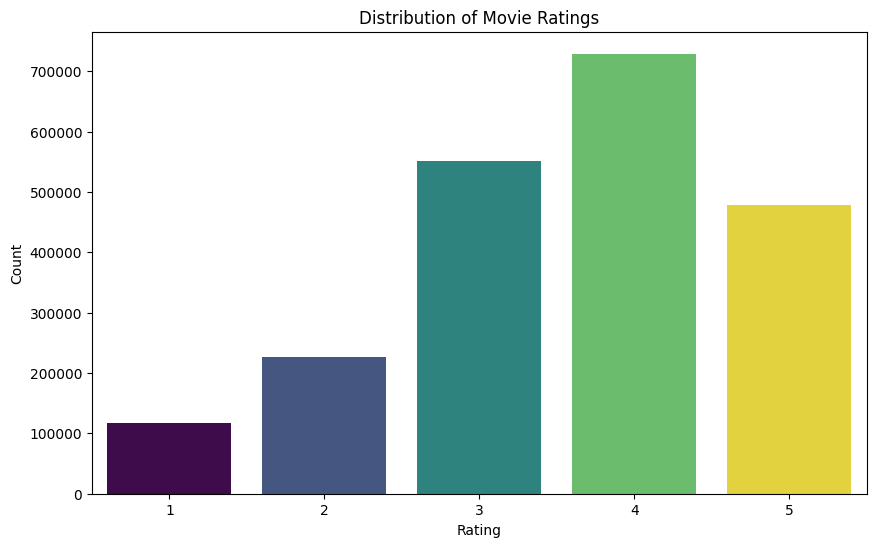

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=data, palette='viridis', hue='rating', legend=False)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


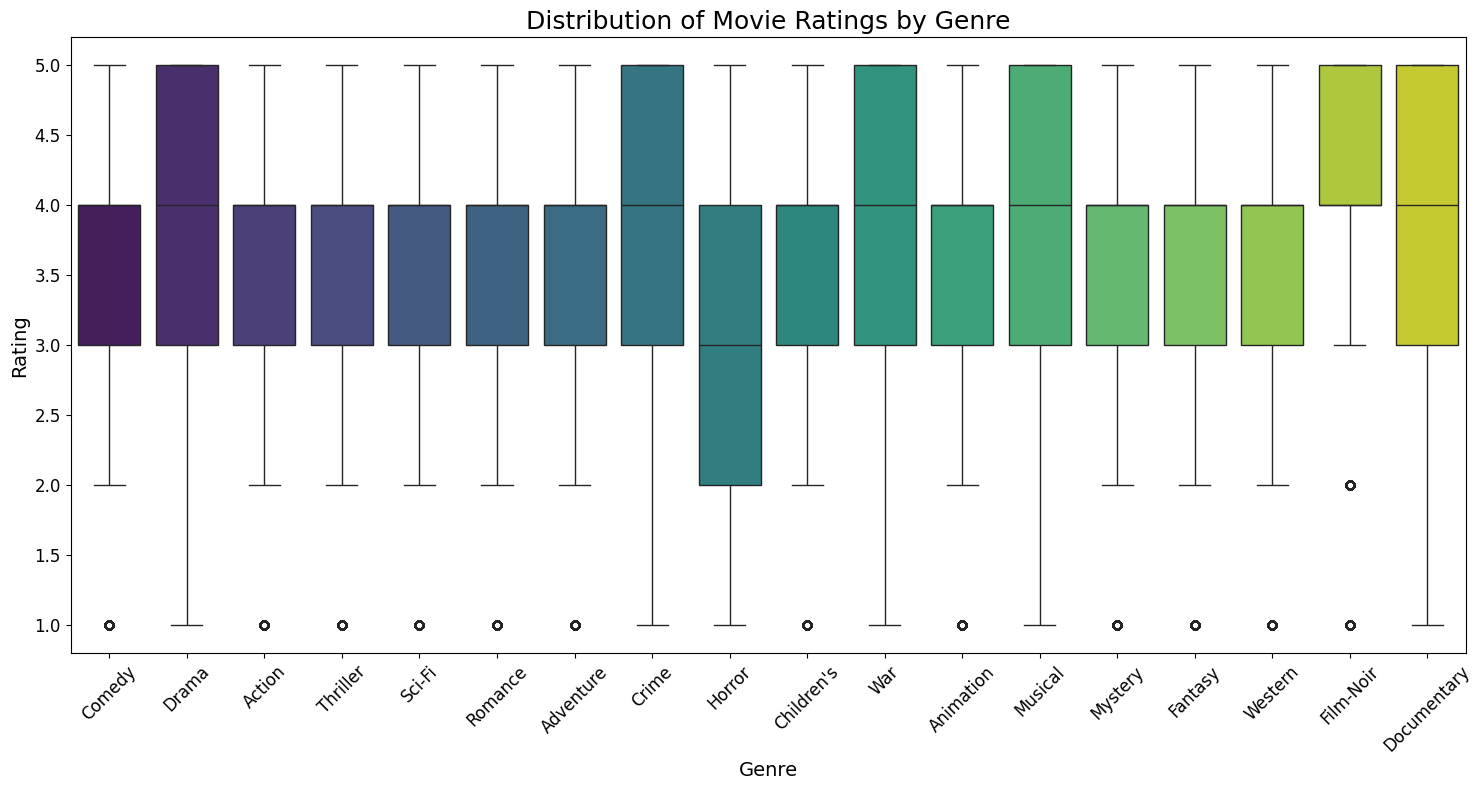

In [ ]:
# Assuming 'data' is a pandas DataFrame with your movie ratings data.
# Convert 'genre' to a category type with orderedness based on count
genre_order = data['genre'].value_counts().index
data['genre'] = pd.Categorical(data['genre'], categories=genre_order, ordered=True)

plt.figure(figsize=(15, 8))
g = sns.boxplot(x='genre', y='rating', data=data, palette='viridis', hue='genre')
g.set_title('Distribution of Movie Ratings by Genre', fontsize=18)
g.set_xlabel('Genre', fontsize=14)
g.set_ylabel('Rating', fontsize=14)
g.tick_params(labelsize=12)
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.tight_layout()  # Adjust layout to fit the rotated x labels
plt.show()


#### Top 20 Movies by Number of Ratings
This bar chart displays the top 20 movies with the highest number of ratings. It helps identify the most popular movies in the dataset based on user engagement.


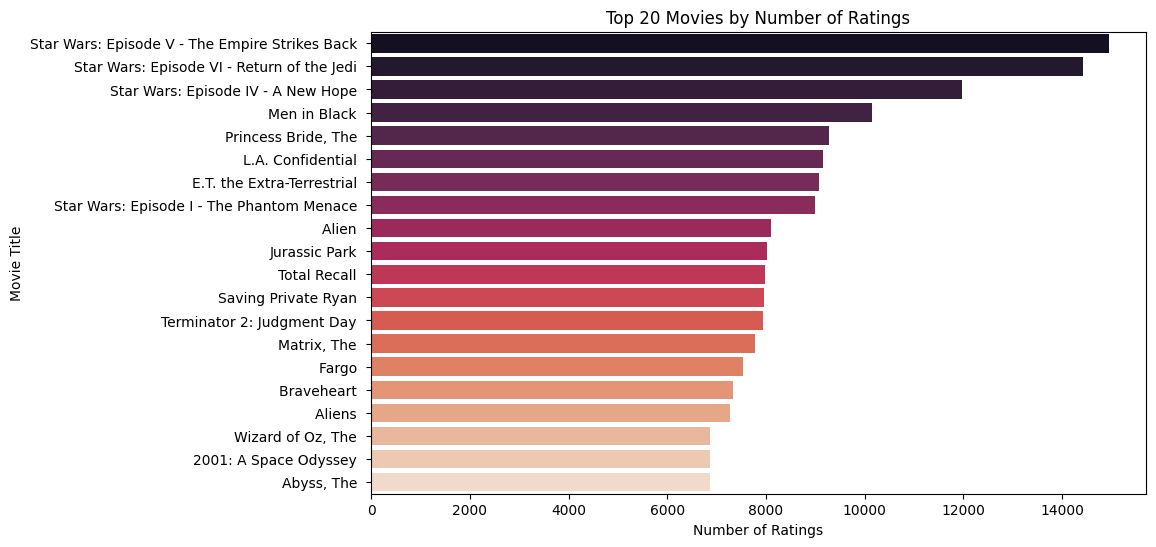

In [ ]:
top_movies = data['title'].value_counts().head(20)
plt.figure(figsize=(10, 6))
sns.barplot(y=top_movies.index, x=top_movies.values, palette='rocket', hue=top_movies.index)
plt.title('Top 20 Movies by Number of Ratings')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')
plt.show()


#### Age Distribution of Users
The histogram represents the age distribution of users who have rated movies. It provides insights into the demographic profile of the user base.


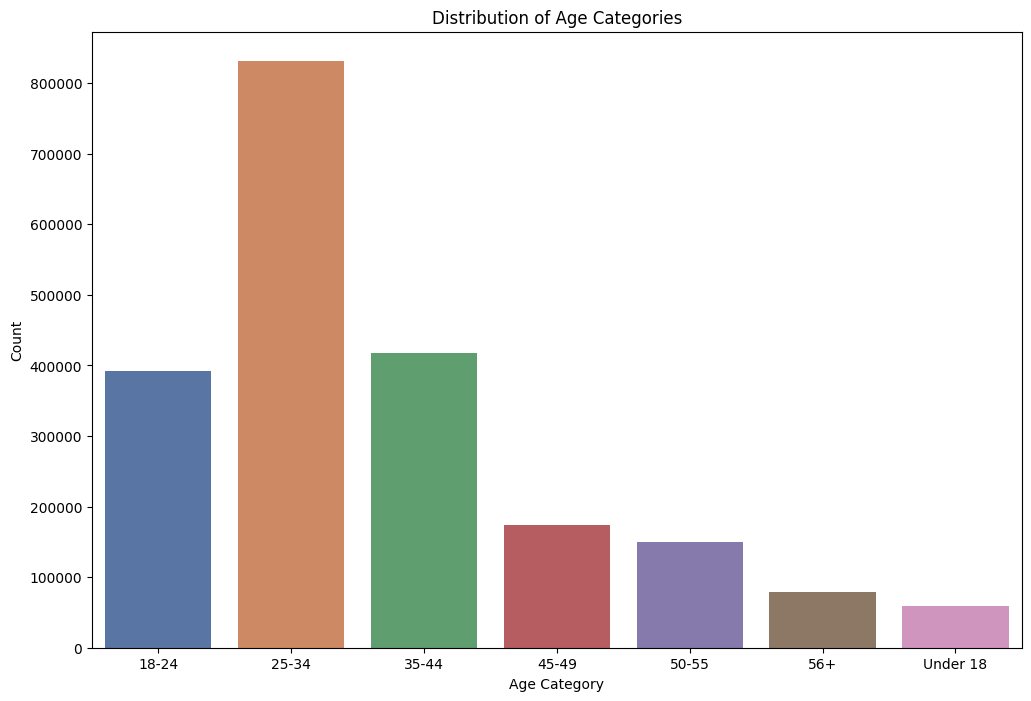

In [ ]:
# create a bar chart for the distribution of age
# count the number of ratings for each age value
age_counts = data['age_categories'].value_counts()

# sort the age values
age_counts = age_counts.sort_index()

# create a bar chart
plt.figure(figsize=(12, 8))

# set the title
plt.title('Distribution of Age Categories')

# set the x-axis label
plt.xlabel('Age Category')

# set the y-axis label
plt.ylabel('Count')

# create a bar chart
sns.barplot(x=age_counts.index, y=age_counts.values, palette='deep', hue=age_counts.index, legend=False)

# show the plot
plt.show()

#### Gender Distribution in Ratings
This chart shows the distribution of ratings across genders, giving an idea of the participation of different genders in movie rating activities.


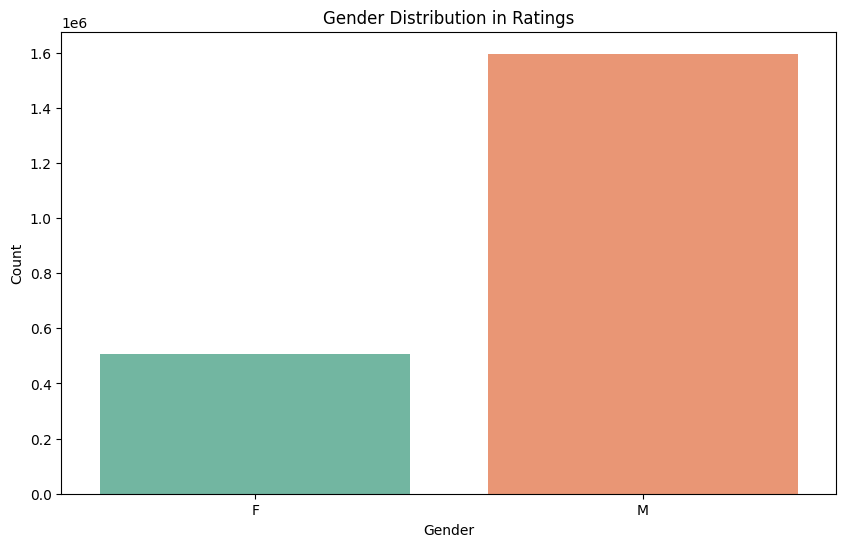

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='gender', data=data, palette='Set2', hue='gender', legend=False)
plt.title('Gender Distribution in Ratings')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()


#### Ratings Over Time (Years)
The graph illustrates the trend in the number of ratings given by users each year. It helps in analyzing the temporal patterns in user engagement with movies.


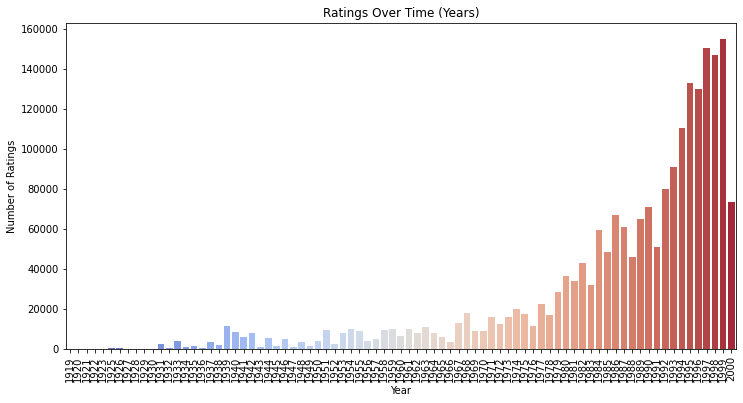

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(x='year', data=data, palette='coolwarm')
plt.title('Ratings Over Time (Years)')
plt.xlabel('Year')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=90)
plt.show()


#### Average Rating by Genre
This bar chart shows the average rating for each movie genre. It's useful for identifying which genres are most favored by users based on their ratings.


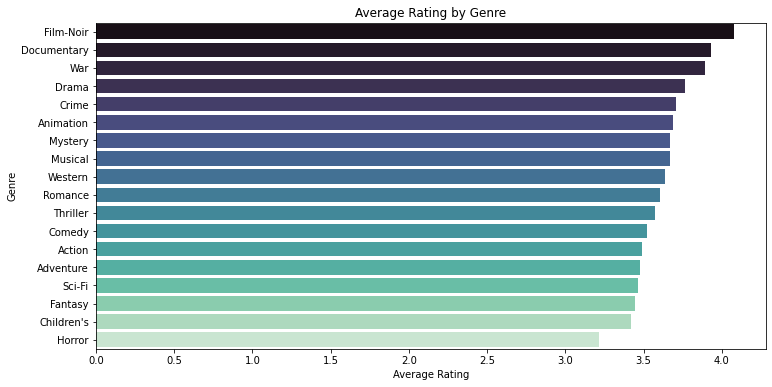

In [ ]:
genre_ratings = data.groupby('genre')['rating'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_ratings.values, y=genre_ratings.index, palette='mako')
plt.title('Average Rating by Genre')
plt.xlabel('Average Rating')
plt.ylabel('Genre')
plt.show()


#### Average Rating by Occupation
This visualization indicates the average movie rating given by users of different occupations. It offers insights into the rating preferences across various occupational groups.


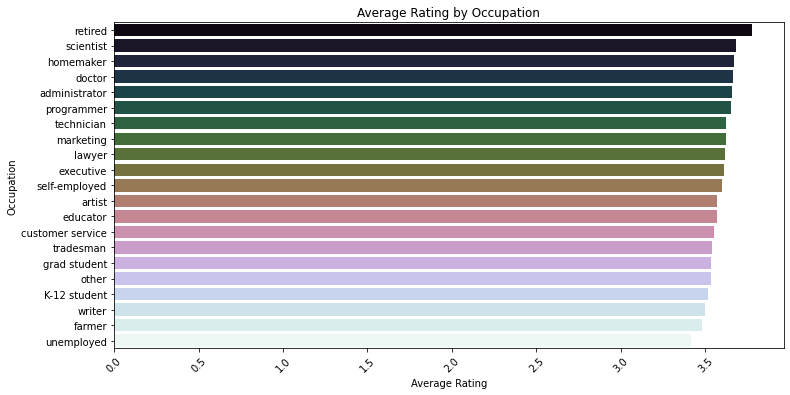

In [ ]:
occupation_ratings = data.groupby('occupation')['rating'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=occupation_ratings.values, y=occupation_ratings.index, palette='cubehelix')
plt.title('Average Rating by Occupation')
plt.xlabel('Average Rating')
plt.ylabel('Occupation')
plt.xticks(rotation=45)
plt.show()


## (iii) Statistical Analysis

##### 1. Descriptive Analysis

For categorical variables of interest: occupation and genre

In [ ]:
# Basic Descriptive Statistics for occupation and genre (categorical) columns
data.describe(include=['object'])[["occupation", "genre", "age_categories"]]

,occupation,genre,age_categories
count,2101815,2101815,2101815
unique,21,18,7
top,grad student,Comedy,25-34
freq,277745,356580,831332


Occupation Distribution: The dataset includes 21 distinct occupation categories, with 'grad students' being the most represented. This is a key consideration for our hypothesis testing, as it suggests a potential skew in movie preferences based on the dominant occupation group. Understanding this distribution is crucial for exploring whether occupation correlates with genre preferences.

Genre Distribution: We have 18 movie genres, with 'Comedy' being the most common. This information sets the baseline for our analysis, allowing us to investigate if certain occupations show a preference for specific genres, in line with our alternative hypothesis.

We are utilizing 'age_categories' in our analysis as the 'age' variable in the dataset is categorical but encoded numerically. This approach will enable us to explore if different age groups, as defined by broader categories, exhibit distinct genre preferences, which could intersect with occupational influences.

For numerical variables of interest: rating, rater age, and year of movie release

In [ ]:
# Basic Descriptive Statistics for rating, and year of movie release (numerical) columns
data.describe(include=['int64', 'float64']).round(2)[["rating", "year"]]

,rating,year
count,2101815.00,2101815.00
mean,3.58,1986.72
std,1.12,14.08
min,1.00,1919.00
25%,3.00,1982.00
50%,4.00,1992.00
75%,4.00,1997.00
max,5.00,2000.00


We see that the average rating for all movies across all users is 3.58, which is slightly above the middle of the 1-5 rating scale. This indicates that users tend to rate movies slightly more positively.

The median rating being higher than the mean implies the presence of lower-end outliers, pulling the mean down. A standard deviation of 1.12 on a 1-5 scale indicates considerable variability in movie ratings. Understanding these rating dynamics is essential for examining whether occupational groups differ significantly in their rating patterns, as posited in our hypotheses.

Since the dataset was curated in the early 2000s, the average movie rated was released sometime in the 1980s and 1990s. The dataset also includes movies as old as 1919 and as recent as 2000. This spread allows us to consider if preferences for certain genres are influenced by the movie's release era, potentially impacting occupation-based preferences.

Note that we have not included "age" as a numerical column of interst since the age column provided in the dataset is actually a categorical variable encoded as a numerical variable. We will be using the age_categories column instead.

**Clarification: why do we want to focus on these informative features?**

Focusing on the categorical variables 'occupation', 'genre', and 'age_categories', along with the numerical variables 'rating' and 'year of movie release', is pivotal for our hypothesis testing. The distinct occupation categories, with a notable representation of 'grad students', may influence genre preferences, which is central to our hypothesis about occupation correlating with genre preferences. The genre distribution, highlighting 'Comedy' as the most common genre, sets a baseline for investigating specific genre preferences among different occupations. The use of 'age_categories' enables us to explore if different age groups have distinct genre preferences, potentially intersecting with occupational influences.

The analysis of 'rating' reveals a slightly positive skew in user ratings and highlights variability in ratings, which is crucial to understand if and how different occupational groups rate movies differently. The 'year of movie release' provides context to these preferences, allowing us to assess if preferences for certain genres are influenced by the movie's release era, further enriching our understanding of the potential impact of occupation on movie preferences.

#### 2. Correlation Analysis

**1. Point-Biserial Correlation between Gender and Rating**

In [ ]:
from scipy.stats import pointbiserialr

# Create a copy of the data
data_copy = data.copy()

# Encode gender as 0 or 1 for point-biserial correlation
data_copy['gender'].replace({'M': 1, 'F': 0}, inplace=True)

# Perform point-biserial correlation and print results
correlation, p_value = pointbiserialr(data_copy['gender'], data_copy['rating'])
print("Point-Biserial Correlation between gender and rating:", correlation)

Point-Biserial Correlation between gender and rating: -0.01959330675043677


The Point-Biserial Correlation between gender (encoded as binary) and ratings helps to understand if there is a linear relationship between gender and how movies are rated. With a correlation value of -0.01959, we observe a very slight negative correlation. This indicates that gender has a minimal influence on ratings, but the strength of this relationship is negligible. This finding is crucial for our hypotheses, as it suggests that gender might not be a significant factor in predicting movie preferences or ratings, allowing us to focus more on other variables like occupation, age and genre.

**2. Pearson Correlation between Year (of movie release) and Rating**

In [ ]:
from scipy import stats

correlation, p_value = data[['rating', 'year']].corr().iloc[0, 1], stats.pearsonr(data['rating'], data['year'])[1]

print(f"Pearson Correlation between rating and year of movie release: {correlation}, P-Value: {p_value}")


Pearson Correlation between rating and year of movie release: -0.16305025225791225, P-Value: 0.0


The Pearson Correlation of -0.163 between movie ratings and the year of release, with a p-value of 0.0, indicates a slight negative correlation that is statistically significant. This suggests that, on average, movies released more recently tend to have slightly lower ratings compared to older movies. The negative value of the correlation coefficient points to this inverse relationship – as the year of release increases (meaning more recent movies), the ratings tend to decrease marginally. The extremely low p-value confirms that this correlation is unlikely to be due to random chance. However, it's important to note that the correlation, while statistically significant, is relatively weak, implying that the year of release is not a strong predictor of movie ratings.

**3. Spearman Rank Correlation between Age and Rating**

In [ ]:
spearman_corr, p_value = stats.spearmanr(data['age'], data['rating'])
print("Spearman Rank Correlation between age and rating:", spearman_corr, "P-Value:", p_value)

Spearman Rank Correlation between age and rating: 0.05022603541837218 P-Value: 0.0


We employ Spearman Rank Correlation to investigate the relationship between age (treated as ordinal) and movie ratings. The correlation coefficient of 0.05022 indicates a weak positive relationship, suggesting that age has a slight influence on how movies are rated. This weak correlation aligns with our hypothesis, indicating that while age might have some influence on movie preferences, it is not a strong determinant, thus pointing us to explore other factors like occupation and genre more thoroughly. The relation is statistically significant, with a p-value of 0.0, indicating that the correlation is not due to chance.

**4. Cramér's V for Occupation and Genre**

In [ ]:
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

cramers_v_result = cramers_v(data['occupation'], data['genre'])
print("Cramér's V for occupation and genre:", cramers_v_result)


Cramér's V for occupation and genre: 0.02783165915665326


Cramér's V is used to measure the association between two nominal variables, in this case, 'occupation' and 'genre'. With a Cramér's V value of 0.02783, the association between these variables is very weak. This insight is critical for our hypothesis testing as it suggests that the correlation between occupation and preferred movie genres, if existent, is not very strong. This result leads us to delve deeper into specific occupation-genre combinations or to consider other factors that might influence movie preferences.

##### 3. Analysis of Categorical Variables

**Average Ratings by Movie Genre**

In [ ]:
data.groupby('genre')['rating'].mean().sort_values(ascending=False)


genre
Film-Noir     4.075
Documentary   3.933
War           3.893
Drama         3.766
Crime         3.709
Animation     3.685
Mystery       3.668
Musical       3.666
Western       3.638
Romance       3.607
Thriller      3.570
Comedy        3.522
Action        3.491
Adventure     3.477
Sci-Fi        3.467
Fantasy       3.447
Children's    3.422
Horror        3.215
Name: rating, dtype: float64

The analysis shows 'Film-Noir', 'Documentary', and 'War' as the top-rated genres. This suggests a general preference for these genres across the user base. The lower average rating for genres like 'Fantasy', 'Children's', and 'Horror' might indicate less universal appeal, given how these genres are more niche. These findings are vital for understanding overall user preferences and provide a baseline for comparing how different occupations rate these genres, which is central to our hypothesis about occupation influencing genre preferences.

**Average Ratings by User Occupation**

In [ ]:
data.groupby('occupation')['rating'].mean().sort_values(ascending=False)

occupation
retired            3.775
scientist          3.682
homemaker          3.671
doctor             3.663
administrator      3.659
programmer         3.651
technician         3.623
marketing          3.621
lawyer             3.618
executive          3.609
self-employed      3.601
artist             3.571
educator           3.569
customer service   3.549
tradesman          3.538
grad student       3.536
other              3.535
K-12 student       3.519
writer             3.496
farmer             3.478
unemployed         3.413
Name: rating, dtype: float64

The analysis reveals that 'retired', 'scientist', and 'homemaker' are the occupations giving the highest average ratings, while 'farmer', 'unemployed', and 'writer' rate movies lower on average. This variation in rating tendencies across occupations is crucial for our hypothesis. It suggests that occupational background might influence how users rate movies, indicating a potential correlation between occupation and movie preferences.

**Best rated genres for each occupation**

In [ ]:
# Group by occupation and genre, then calculate the average rating
avg_ratings = data.groupby(['occupation', 'genre'])['rating'].mean().reset_index()

# Finding the highest rated genre for each occupation
best_rated_genres = avg_ratings.loc[avg_ratings.groupby('occupation')['rating'].idxmax()]

best_rated_genres.sort_values(by='rating', ascending=False)

,occupation,genre,rating
9,K-12 student,Film-Noir,4.212766
279,scientist,Film-Noir,4.190476
261,retired,Film-Noir,4.161058
189,lawyer,Film-Noir,4.145251
243,programmer,Film-Noir,4.130357
207,marketing,Film-Noir,4.126050
45,artist,Film-Noir,4.114000
297,self-employed,Film-Noir,4.105583
369,writer,Film-Noir,4.104603
99,educator,Film-Noir,4.082613


Interestingly, 'Film-Noir' emerges as the highest-rated genre for many occupations, while 'Documentary' and 'War' are also top-rated in certain groups. This specific preference pattern is highly relevant to our hypothesis, indicating that certain occupations have distinct genre preferences. The consistent high rating for 'Film-Noir' across various occupations might reflect a universal appeal of this genre among diverse occupational groups. This insight is crucial for our hypothesis, as it suggests that occupation might influence movie preferences, leading us to explore this relationship further.

#### 4. ANOVA Analysis


In [ ]:
import scipy.stats as stats

# Get unique occupations
occupations = data['occupation'].unique()

# Iterate over each occupation
for occupation in occupations:
    # Group data by occupation and genre, then list ratings
    grouped_data = data[data['occupation'] == occupation].groupby('genre')['rating'].apply(list)

    # Perform ANOVA if there are enough data points
    if len(grouped_data) > 1 and all(len(ratings) > 1 for ratings in grouped_data):
        f_value, p_value = stats.f_oneway(*grouped_data)
        print(f'ANOVA for {occupation}: F-Value: {f_value}, P-Value: {p_value}')
    else:
        print(f'Not enough data to perform ANOVA for {occupation}')


ANOVA for K-12 student: F-Value: 57.009915935443, P-Value: 2.8640057550011396e-193
ANOVA for self-employed: F-Value: 115.59300497953507, P-Value: 0.0
ANOVA for programmer: F-Value: 120.34768208775675, P-Value: 0.0
ANOVA for executive: F-Value: 221.28225959637612, P-Value: 0.0
ANOVA for educator: F-Value: 250.09123608596312, P-Value: 0.0
ANOVA for administrator: F-Value: 56.2091889367738, P-Value: 8.318934383982504e-191
ANOVA for grad student: F-Value: 304.02599479800665, P-Value: 0.0
ANOVA for farmer: F-Value: 5.720454268720781, P-Value: 3.807369266901621e-13
ANOVA for technician: F-Value: 162.84356697805404, P-Value: 0.0
ANOVA for other: F-Value: 337.4632543377334, P-Value: 0.0
ANOVA for artist: F-Value: 100.2085253242381, P-Value: 0.0
ANOVA for homemaker: F-Value: 18.291862386737996, P-Value: 1.52669660135494e-55
ANOVA for unemployed: F-Value: 36.907804901837835, P-Value: 4.400925431812419e-121
ANOVA for tradesman: F-Value: 25.113945140450937, P-Value: 2.2529491149582612e-79
ANOVA fo

##### ANOVA test implications:

The ANOVA results demonstrate significant differences in movie genre ratings across various occupations, strongly supporting our alternative hypothesis (H_a) that occupation correlates with genre preferences. The high F-values combined with the consistently low P-Values across nearly all occupations indicate these differences are statistically significant and not due to random chance. This suggests that an individual's occupation has a notable influence on their movie genre preferences, with certain occupations consistently rating some genres higher or lower than others.

For instance, the high F-Values and near-zero P-Values for occupations like 'grad student', 'executive', and 'educator' imply distinct rating patterns for these groups. This aligns well with our hypothesis and provides a clear indication that occupational background is a significant factor in how different movie genres are perceived and rated.

These findings are critical for understanding audience preferences in the movie industry, affirming that occupational background is a valuable determinant of movie genre preferences.

## Milestone 3

In [ ]:

# load dataset from cleaned_data/ folder and libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


# load dataset from cleaned_data/ folder
data = pd.read_csv('cleaned_data/merged_df.csv')

print(data.shape)

data.head()


(2101815, 12)


,userid,movieid,rating,rating date,gender,age,zip-code,occupation,age_categories,title,genre,year
0,1,1193,5,2000-12-31,F,1,48067,K-12 student,Under 18,One Flew Over the Cuckoo's Nest,Drama,1975
1,2,1193,5,2000-12-31,M,56,70072,self-employed,56+,One Flew Over the Cuckoo's Nest,Drama,1975
2,12,1193,4,2000-12-30,M,25,32793,programmer,25-34,One Flew Over the Cuckoo's Nest,Drama,1975
3,15,1193,4,2000-12-30,M,25,22903,executive,25-34,One Flew Over the Cuckoo's Nest,Drama,1975
4,17,1193,5,2000-12-30,M,50,95350,educator,50-55,One Flew Over the Cuckoo's Nest,Drama,1975


**1. Outlier Analysis**

In our analysis of the MovieLens 1M dataset, we perform outlier detection primarily on the 'ratings' variable. This is because ratings are a key metric in understanding viewer preferences and are crucial for testing our hypothesis about the correlation between occupation, and genre preferences (while also looking at potentially confounding variables such as rater age and year of movie release). Ratings, being numerical and ranging from 1 to 5, are well-suited for outlier detection to identify atypical responses that might skew our analysis. Unlike 'ratings', other variables in our dataset, such as 'occupation', 'genre', and 'age categories', are categorical, making traditional outlier detection techniques less applicable. Focusing on ratings ensures that our analysis accurately reflects general viewer sentiment and preferences without being disproportionately influenced by extreme values.

1. **IQR Method**

In [ ]:
# IQR method for outlier detection
Q1 = data['rating'].quantile(0.25)
Q3 = data['rating'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_IQR = data[(data['rating'] < lower_bound) | (data['rating'] > upper_bound)]
print("Number of outliers using IQR method:", len(outliers_IQR))


Number of outliers using IQR method: 116603


2. **Z-Score Method**

In [ ]:
# Z-score method for outlier detection
from scipy import stats
import numpy as np

# Z-score method for outlier detection
z_scores = stats.zscore(data['rating'])
abs_z_scores = np.abs(z_scores)
outliers_Z = data[abs_z_scores > 3]
print("Number of outliers using Z-score method:", len(outliers_Z))


Number of outliers using Z-score method: 0


3. **Standard Deviation Method**

In [ ]:
# Standard Deviation method for outlier detection
mean_rating = data['rating'].mean()
std_rating = data['rating'].std()
cutoff = std_rating * 3  # Assuming 3 standard deviations from mean

lower, upper = mean_rating - cutoff, mean_rating + cutoff
outliers_std = data[(data['rating'] < lower) | (data['rating'] > upper)]
print("Number of outliers using Standard Deviation method:", len(outliers_std))


Number of outliers using Standard Deviation method: 0


**Analysis of our Outlier Detection Methods:**

1. IQR Method: The IQR method identifies outliers based on the interquartile range. It flags ratings that are 1.5 times the IQR below the first quartile or above the third quartile as outliers. This method is effective for data that is not too skewed, but in the context of a bounded rating scale (1-5), it might flag legitimate low or high ratings as outliers.

2. Z-Score Method: The Z-score method calculates how many standard deviations away each rating is from the mean. Ratings with a Z-score greater than 3 (or less than -3) are typically considered outliers. This method assumes that the data follows a normal distribution, which might not be the case for a discrete rating scale.
Standard Deviation Method Analysis

3. The Standard Deviation method: The standard deviation method identifies outliers as ratings that are a certain number of standard deviations away from the mean. In this case, we used 3 standard deviations as a threshold. This method is similar to the Z-score method and also assumes a normal distribution of data.

Given the nature of the MovieLens dataset, where ratings range from 1 to 5, traditional outlier detection methods may not be entirely appropriate. Ratings of 1, while technically outliers in the IQR method, are valid expressions in a movie rating context. Therefore, it might be more insightful to consider these ratings as part of our analysis rather than excluding them as outliers. This approach ensures a comprehensive understanding of viewer preferences across the entire rating spectrum.

### Further correlation analysis (based on feedback received during the presentation)

In [ ]:
# Create a copy of the data
data_copy = data.copy()

# Encode gender as 0 or 1 for point-biserial correlation
data_copy['gender'].replace({'M': 1, 'F': 0}, inplace=True)

# Cramér's V for gender and genre
gender_genre = cramers_v(data_copy['gender'], data_copy['genre'])
print("Cramér's V for gender and genre:", gender_genre)



Cramér's V for gender and genre: 0.118229079993821


Here, we see that there is a weak positive correlation between gender and genre preferences. This indicates that we can potentially use gender as a feature in our predictive model.

### Reasoning the choice of correlated features

In our analysis, the selection of features such as gender, occupation, age, and genre is grounded in the hypothesis that these demographic and categorical attributes may have a significant impact on movie preferences and ratings.

- **Occupation and Genre**: The choice to focus on occupation and genre stems from the hypothesis that different occupational backgrounds might influence individual preferences for certain movie genres. For instance, individuals in creative fields might prefer genres like drama or art films, while those in technical fields might lean towards sci-fi or action.

- **Age and Genre Preferences**: Age as a variable is selected based on the premise that movie preferences could vary across different age groups. Different generations may have distinct tastes in movies, influenced by cultural and social factors prevalent during their formative years.

- **Gender and Movie Preferences**: The inclusion of gender is to explore whether there are discernible patterns in movie preferences based on gender. This is in line with numerous studies that suggest gender may play a role in shaping entertainment choices.

- **Correlation Exploration**: The analysis aims to explore potential correlations between these selected features and movie ratings. For example, whether certain genres are consistently rated higher by specific occupational groups, or if age and gender correlate with a preference for certain types of movies.

By analyzing the interplay between these features and movie ratings, the study seeks to uncover nuanced insights into how demographic factors might influence movie preferences. This understanding could be valuable for targeted marketing, content creation, and enhancing user experience in streaming platforms or movie production.

## Modeling based on our hypothesis

Since we have observed that differences in movie genre ratings across occupations are statistically significant, we can use this information to build a model that predicts the genre that a user is most likely to rate highly based on their occupation. This model can be used to understand the preferences of different occupational groups and inform targeted marketing campaigns.

**1. Data Preparation**

One-Hot Encoding: We use one-hot encoding to convert categorical variables like 'occupation' and 'age_categories' into vectorized features. This is necessary for our model to process these variables.

In [ ]:
# One-hot encode categorical variables
data_onehot = pd.get_dummies(data[['age_categories', 'gender', 'occupation']], drop_first=True)

X = data_onehot

# Target variable
y = data['genre']

# Display the processed data
print("Processed Features (X):")
X.head()

# printing all columns
print("All Columns:")
print(X.columns)

Processed Features (X):
All Columns:
Index(['age_categories_25-34', 'age_categories_35-44', 'age_categories_45-49',
       'age_categories_50-55', 'age_categories_56+', 'age_categories_Under 18',
       'gender_M', 'occupation_administrator', 'occupation_artist',
       'occupation_customer service', 'occupation_doctor',
       'occupation_educator', 'occupation_executive', 'occupation_farmer',
       'occupation_grad student', 'occupation_homemaker', 'occupation_lawyer',
       'occupation_marketing', 'occupation_other', 'occupation_programmer',
       'occupation_retired', 'occupation_scientist',
       'occupation_self-employed', 'occupation_technician',
       'occupation_tradesman', 'occupation_unemployed', 'occupation_writer'],
      dtype='object')


In [ ]:
print("\nTarget Variable (y):")
y.head()

# printing all y values
print("All y values:")
print(y.unique())


Target Variable (y):
All y values:
['Drama' 'Animation' "Children's" 'Musical' 'Romance' 'Comedy' 'Action'
 'Adventure' 'Fantasy' 'Sci-Fi' 'War' 'Thriller' 'Crime' 'Mystery'
 'Western' 'Horror' 'Film-Noir' 'Documentary']


Here we create the training and test datasets for our model. We use 80% of the data for training and 20% for testing. Note that we use the stratify parameter to ensure that the training and test datasets have a similar distribution of ratings. This is important to ensure that our model is trained on a representative sample of the data.

In [ ]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Display the shapes
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1681452, 27), (420363, 27), (1681452,), (420363,))

**2. Model Training**

We use the Random Forest Classifier to train our model. This is a supervised learning algorithm that uses an ensemble of decision trees to make predictions. It's a popular algorithm for classification tasks and is known for its robustness and accuracy.

We train a naive model without any extra hyperparameter tuning to establish a baseline for comparison. If this does well, we can try to improve the model's performance by tuning the hyperparameters. If not, a different modeling strategy might be required.

In [ ]:
# Initialize the RandomForest classifier
random_forest_classifier = RandomForestClassifier(random_state=42)

# Train the classifier
random_forest_classifier.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = random_forest_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

C:\Users\zaeem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.18234002516872322
F1 Score: 0.1051467014633058
Precision: 0.1558811252453494
Recall: 0.18234002516872322


We see that an accuracy of 18% is achieved which is far worse than any suitable recommendation system. Below, we test the Logistic Regression to see if it performs better. If the performance is similar, we will need to explore other modeling strategies as this problem cannot be solved better by simply tuning the hyperparameters and choosing the "best" model.

In [ ]:
# Initialize the Logistic Regression classifier
logistic_regression = LogisticRegression(random_state=42)

# Train the classifier
logistic_regression.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = logistic_regression.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

C:\Users\zaeem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\zaeem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resul

Accuracy: 0.18017285060768906
F1 Score: 0.09832658494145255
Precision: 0.07989394655785018
Recall: 0.18017285060768906


Since the Logistic Regression performs similarly to the Random Forest Classifier, we can conclude that this problem cannot be solved by simply tuning the hyperparameters of the model. We will need to explore other modeling strategies to improve the performance.

### Improved Naive Model (based on feedback received during the presentation)


#### Focusing on Higher Ratings
Our revised model now considers only ratings of 4 or higher, aligning more closely with user preferences. This shift from including all ratings to focusing on higher ones ensures that the model predicts genres that users genuinely enjoy.

#### Adopting Multi-Label Classification
Initially, our model mapped each demographic profile to a single genre, which oversimplified user preferences. Recognizing that users often enjoy multiple genres, we have transitioned to a multi-label classification approach. This change allows our model to predict a set of top genres for each user with a unique demographic combination, offering a more nuanced and accurate reflection of diverse user preferences.

#### Implementation Highlights
- **Data Refinement**: We filter for ratings of 4 or higher to train our model on preferred genres.
- **Grouping and Aggregation**: Data is grouped by age categories, occupation, and gender, with genres aggregated to capture varied preferences.
- **Multi-Label Encoding**: The `MultiLabelBinarizer` is used for handling multiple genres, preparing the dataset for multi-label classification.
- **Model Adaptation**: A `OneVsRestClassifier` with `LogisticRegression` is implemented, suitable for multi-label scenarios.
- **Evaluation Approach**: Accuracy and F1 score metrics are employed, tailored to the multi-label classification framework.

These improvements make our genre recommendation system more reflective of the complex nature of user preferences, enhancing its relevance and accuracy.

--- 

This concise version maintains the essence of the enhancements in your predictive model, focusing on key changes and their implications for the recommendation system.

In [17]:

import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, f1_score
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Load dataset
data = pd.read_csv('cleaned_data/merged_df.csv')
data = data[data['rating'] >= 4]

# Group by age_categories, occupation, and gender and aggregate genres
grouped_data = data.groupby(['age_categories', 'occupation', 'gender'])['genre'].apply(set).reset_index()

# Prepare the target variable using MultiLabelBinarizer
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(grouped_data['genre'])

# Feature Engineering
data_encoded = pd.get_dummies(grouped_data[['age_categories', 'occupation', 'gender']])

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_encoded, genres_encoded, test_size=0.3, random_state=42)

# Model Training with OneVsRestClassifier
model = OneVsRestClassifier(LogisticRegression(max_iter=1000))
model.fit(X_train, y_train)

# Model Evaluation
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='macro'))

Accuracy: 0.7945205479452054
F1 Score: 0.9808618385518884


_The results demonstrate that our model is highly capable of predicting a range of genres that align with the varied preferences of users, as defined by their age, occupation, and gender. The high F1 score, in particular, reinforces the model's reliability and robustness in making these predictions. These metrics collectively validate the effectiveness of the enhancements made to our genre recommendation system._

Despite the effectiveness of our current model in predicting user preferences based on demographic information, it's still crucial to implement collaborative filtering. 

- Before we were answering the following question:
"If a new user enters the system, can we recommend movies to them by predicting the genre they are most likely to like the most given their age, occupation, and gender?"
- Now we want to address the following question:
"Given a user's rating history, can we recommend movies to them by comparing them to other users with similar rating patterns?"

This approach is essential because:

1. **Personalization**: Collaborative filtering tailors recommendations based on user behavior, capturing unique tastes that demographic-based models might miss.

2. **Dynamic Adaptation**: It adjusts recommendations based on evolving user interactions, ensuring that suggestions remain relevant over time.

3. **Diversity of Recommendations**: Collaborative filtering can uncover hidden patterns and suggest diverse items that users might not discover through demographic-based filtering alone.

In summary, collaborative filtering complements our model by adding depth and dynamism to the recommendation process, enhancing overall user experience.

# Collaborative Filtering Recommender System

## Introduction to Collaborative Filtering and Singular Value Decomposition (SVD)

We are implementing a movie recommender system using collaborative filtering, a popular method in recommendation engines. Collaborative filtering is based on the idea of predicting a user's preferences and interests by collecting preferences from many users. This method assumes that if a person A has the same opinion as a person B on an issue, A is more likely to have B's opinion on a different issue than that of a random person.

### Collaborative Filtering: An Overview
- **User-Based**: Recommendations are made for a user based on the preferences of similar users.
- **Item-Based**: Recommendations are based on the similarity between items calculated using users' ratings of those items.

### Singular Value Decomposition (SVD) in Collaborative Filtering
- SVD is a matrix factorization technique that is widely used for dimensionality reduction and latent feature extraction in data.
- In the context of a recommender system, SVD decomposes the user-item rating matrix into three matrices:
    - **User Matrix (U)**: Represents the relationship between users and latent factors.
    - **Singular Values (Σ)**: Diagonal matrix representing the strength of each latent factor.
    - **Item Matrix (V^T)**: Represents the relationship between items (movies) and latent factors.
- These matrices help uncover latent structures in the user-item interactions, such as common patterns, preferences, and user-item relationships.

### Application of SVD in Our Project
- We apply SVD to the user-item matrix derived from movie ratings to extract latent factors.
- The latent factors capture the underlying patterns in the movie ratings, which are not immediately observable.
- The model uses these factors to predict missing ratings and thus can recommend movies to a user that they have not yet watched but are likely to rate highly.



### Process Overview:
1. **Data Preparation**: Prepare the user-item interaction data.
2. **Model Selection**: Choose an appropriate model for collaborative filtering.
3. **Model Training**: Train the model on the dataset.
4. **Generating Recommendations**: Use the model to generate movie recommendations.


## Data Preparation

In this section, we prepare the foundational element of our collaborative filtering model - the user-item interaction matrix. This matrix is pivotal in understanding and modeling the relationships between users and movies based on their interactions, typically represented by ratings.

#### User-Item Matrix
- Rows represent individual users.
- Columns represent movies.
- Values in the matrix are the ratings given by users to movies.
- Unrated movies are filled with a value of 0, assuming that unrated means no interaction.

#### Sparse Matrix Conversion
- For efficiency and to handle the sparsity of data (since not all users rate all movies), we convert this matrix into a sparse format.
- Sparse matrices are more memory-efficient and are crucial for handling large datasets.


In [1]:
import pandas as pd
from scipy.sparse import csr_matrix

# load dataset from cleaned_data/ folder
data = pd.read_csv('cleaned_data/merged_df.csv')

# Creating the user-item matrix
user_item_matrix = data.pivot_table(index='userid', columns='movieid', values='rating').fillna(0)

# Convert to sparse matrix for efficiency
user_item_sparse = csr_matrix(user_item_matrix.values)


## Model Selection and Training

#### Model Selection: Singular Value Decomposition (SVD)
- We choose SVD, a powerful matrix factorization technique, known for its efficiency in latent factor identification.
- Latent factors are underlying characteristics or patterns inferred from the data, which help in predicting user preferences.

#### Model Training
- The SVD model is trained on the user-item sparse matrix.
- This training process decomposes the matrix into factors that capture the underlying structure in the user-rating patterns.
- The number of latent factors (`n_components`) is a crucial hyperparameter that influences the model's ability to capture complexities in the data.


In [2]:
from sklearn.decomposition import TruncatedSVD

# Choosing the model - SVD
n_components = 15  # number of latent factors
model = TruncatedSVD(n_components=n_components)


## Model Training

With our model selected, the next step is to train it on the user-item matrix. This process involves decomposing the matrix into components that capture the patterns in user ratings.


In [3]:
# Training the model
model.fit(user_item_sparse)

TruncatedSVD(n_components=15)

## Recommendation Generation and Validation

#### Generating Recommendations
- After training the model, we use it to predict user ratings for all movies.
- By reconstructing the user-item matrix, we obtain a matrix of predicted ratings.
- We then generate movie recommendations for a specific user based on these predicted ratings.

#### Validation of Recommendations
- To validate our model, we look at the user's past high ratings (4 or higher).
- By comparing the genres of highly-rated movies by the user with the genres of recommended movies, we can assess the alignment and accuracy of our recommendations.
- This qualitative assessment helps in understanding the model's performance from a user-centric perspective.


In [4]:
import numpy as np

# Reconstructing the user-item matrix
reconstructed_matrix = model.transform(user_item_sparse)
reconstructed_matrix = model.inverse_transform(reconstructed_matrix)


In [12]:
# Generating recommendations for a user
user_id = 23  # example user ID
user_ratings = reconstructed_matrix[user_item_matrix.index.get_loc(user_id)]
recommended_movie_indices = np.argsort(-user_ratings)[:10]  # top 10 recommendations

# Mapping indices to movie titles
recommended_movie_ids = user_item_matrix.columns[recommended_movie_indices]
recommended_titles = data[data['movieid'].isin(recommended_movie_ids)]['title'].drop_duplicates().tolist()

print("Top 10 Movie Recommendations for User ID", user_id, ":")
for title in recommended_titles:
    # print its title and all its genres as there are multiple genres per movie
    print(title, "-", set(data[data['title'] == title]['genre'].values))


Top 10 Movie Recommendations for User ID 23 :
Star Wars: Episode IV - A New Hope  - {'Action', 'Sci-Fi', 'Adventure', 'Fantasy'}
Total Recall  - {'Action', 'Sci-Fi', 'Adventure', 'Thriller'}
Terminator 2: Judgment Day  - {'Action', 'Sci-Fi', 'Thriller'}
Matrix, The  - {'Action', 'Sci-Fi', 'Thriller'}
Men in Black  - {'Comedy', 'Action', 'Sci-Fi', 'Adventure'}
Alien  - {'Action', 'Sci-Fi', 'Thriller', 'Horror'}
Terminator, The  - {'Action', 'Sci-Fi', 'Thriller'}
Twelve Monkeys  - {'Drama', 'Sci-Fi'}
Aliens  - {'Action', 'Sci-Fi', 'Thriller', 'War'}
Blade Runner  - {'Sci-Fi', 'Film-Noir'}


As we can see above, the model has generated the top 10 recommendations for our test user 23. These movies are predicted to have the highest ratings for this user, based on their past ratings and the ratings of similar users.

In [14]:
# create a dataframe for ratings 4 or higher for user 39
testuser = data[(data['userid'] == user_id) & (data['rating'] >= 4)]

print("Genres rated 4 or higher by User ID", user_id, ":")
# show the count of ratings for each genre for these high ratings
print(testuser['genre'].value_counts().head(6))

Genres rated 4 or higher by User ID 23 :
Sci-Fi       56
Action       50
Comedy       42
Thriller     36
Drama        29
Adventure    26
Name: genre, dtype: int64


#### Assessing the Accuracy of Recommendations

To evaluate the accuracy of our recommender system's suggestions, it is imperative to analyze the alignment of the recommendations with the user's established preferences. One effective method to achieve this is by manually examining the genre distribution of movies that the user has favorably rated in the past.

In the case of user 23, we investigate the count of movie genres that have received a rating of 4 or higher. This analysis provides insight into the user's preferred genres, thereby serving as a benchmark to assess the relevance of the recommended movies.

Upon review, it is observed that user 23 demonstrates a preference for a diverse array of genres, prominently including 'Sci-Fi', 'Action', 'Comedy', 'Thriller', and 'Drama'. Notably, the genres of the recommended movies encompass this spectrum of interests, indicating a high degree of alignment with the user's tastes. This congruence between the user's preferred genres and the genres of the recommended movies lends credibility to the accuracy and relevance of the recommendations generated by our model.

Consequently, based on this genre-based validation approach, we can assert with a reasonable degree of confidence that our collaborative filtering model is capable of generating recommendations that are both accurate and tailored to the individual preferences of the users.


## Visualizing the Latent Feature Space from SVD


In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Extract user and movie matrices from the trained SVD model
user_matrix = model.transform(user_item_sparse)
movie_matrix = model.components_.T  # Transpose to align with user matrix

# For 2D visualization, use the first two components
user_2d = user_matrix[:, :2]
movie_2d = movie_matrix[:, :2]

# For 3D visualization, use the first three components (if available)
user_3d = user_matrix[:, :3] if user_matrix.shape[1] >= 3 else user_matrix
movie_3d = movie_matrix[:, :3] if movie_matrix.shape[1] >= 3 else movie_matrix


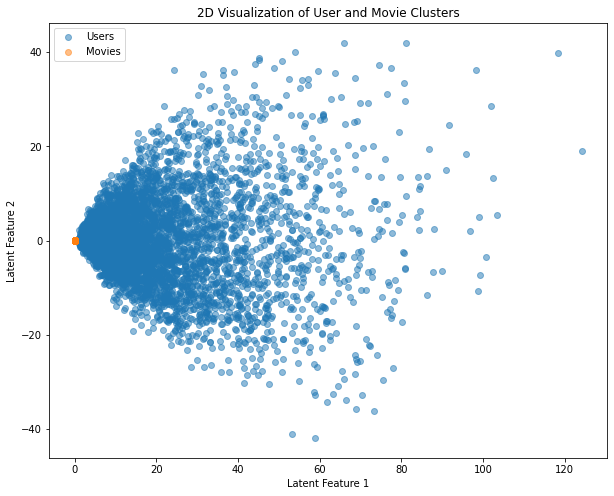

In [8]:
plt.figure(figsize=(10, 8))
plt.scatter(user_2d[:, 0], user_2d[:, 1], alpha=0.5, label='Users')
plt.scatter(movie_2d[:, 0], movie_2d[:, 1], alpha=0.5, label='Movies')
plt.xlabel('Latent Feature 1')
plt.ylabel('Latent Feature 2')
plt.title('2D Visualization of User and Movie Clusters')
plt.legend()
plt.show()


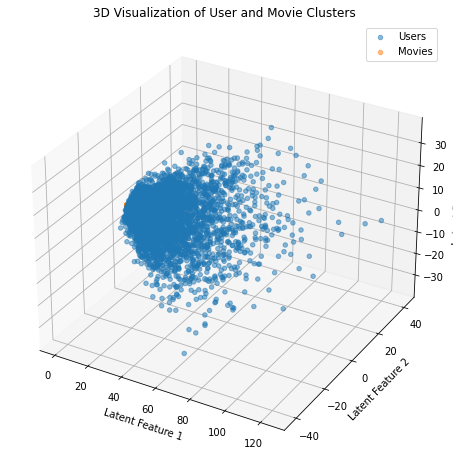

In [9]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(user_3d[:, 0], user_3d[:, 1], user_3d[:, 2], alpha=0.5, label='Users')
ax.scatter(movie_3d[:, 0], movie_3d[:, 1], movie_3d[:, 2], alpha=0.5, label='Movies')
ax.set_xlabel('Latent Feature 1')
ax.set_ylabel('Latent Feature 2')
ax.set_zlabel('Latent Feature 3')
plt.title('3D Visualization of User and Movie Clusters')
plt.legend()
plt.show()


The scatter plots above represent our collaborative filtering model's latent feature space derived from Singular Value Decomposition (SVD). In these visualizations, each point corresponds to either a user or a movie, positioned according to their associated latent features, which are the result of decomposing the user-item rating matrix.

These plots are a simplified representation of complex multidimensional data. While they provide intuitive insights into the structure of the data and the model's behavior, the actual recommendation process considers the full multi-dimensional latent feature space, which is challenging to visualize completely on a 2D screen.
